In [1]:
import datetime as dt
today = dt.datetime.now() 
print('This notebook was last updated on', today.strftime('%A %B %d, %Y at %H:%M'))   

This notebook was last updated on Sunday December 13, 2020 at 09:35


In [90]:
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import rc
from matplotlib import ticker
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

sys.path.append('./utils')

# see https://github.com/dangeles/dangeles.github.io/blob/master/jupyter/utils/covid_utils.py
import covid_utils as cv 

In [91]:
# load into a dataframe:
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')

# merge dfs:
df = df.merge(pop, left_on='state', right_on='state')

# calculate per population numbers:
df['normedPopCases'] = df.cases/ df[2019]
df['normedPopDeaths'] = df.deaths / df[2019]

# find max:
cases = df.groupby('state').cases.apply(max).sum()
death_toll = df.groupby('state').deaths.apply(max).sum()

print('Cases in the US at last update: {0:.2f}'.format(cases / 10 ** 6), 'million')
print('Death toll in the US at last update: {0:.0f} thousand'.format(death_toll / 10 ** 3))
print('Daily deaths: {0}'.format(df.groupby(['date']).deaths.apply(np.sum).diff().values[-1]))

Cases in the US at last update: 16.17 million
Death toll in the US at last update: 298 thousand
Daily deaths: 2257.0


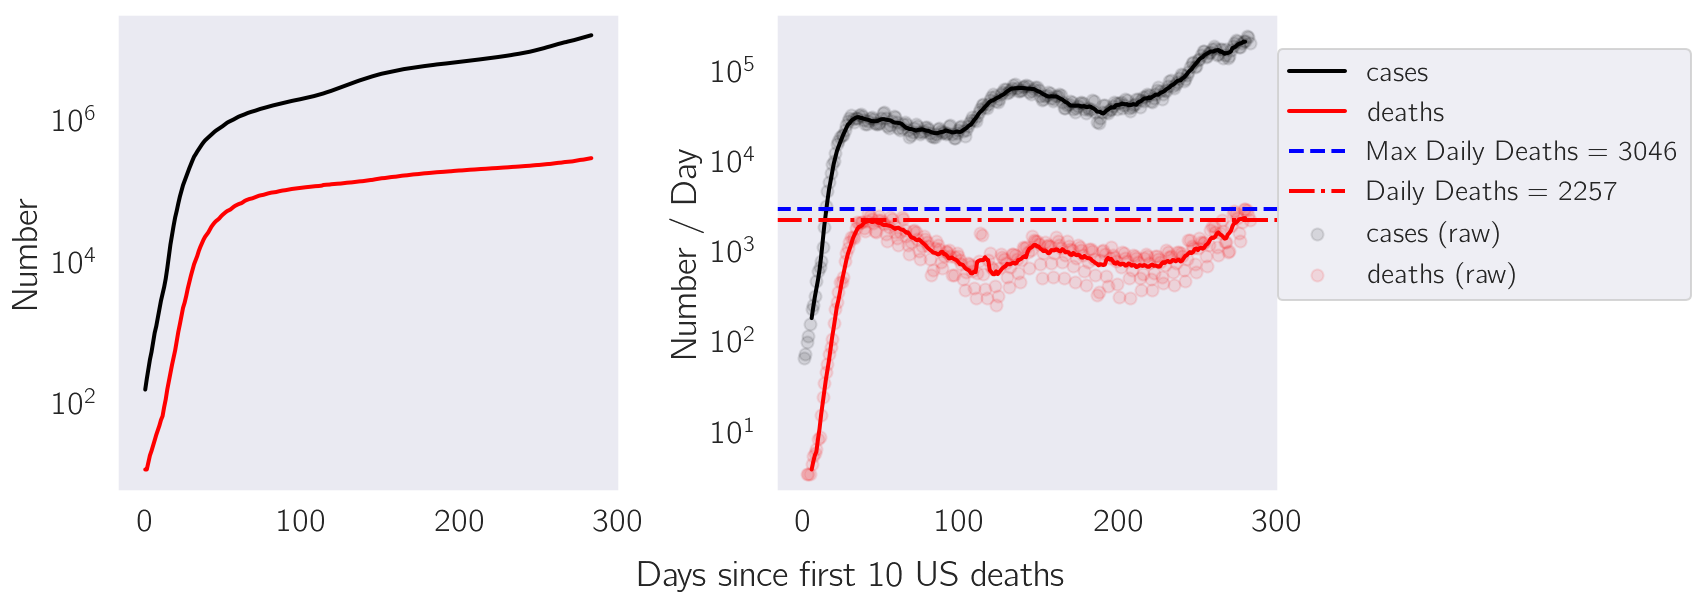

In [92]:
us  = df.groupby('date')[['cases', 'deaths']].sum().reset_index()
us = us[us.date >= us[us.deaths > 10].date.min()]
us['RefTime'] = (us.date - us.date.min()) / dt.timedelta(days=1)

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(12, 4))

ax[0].plot(us.RefTime, us.cases, color='black', label='cases')
ax[0].plot(us.RefTime, us.deaths, color='red', label='deaths')
ax[1].plot(us.RefTime, us.cases.diff().rolling(win_type='exponential',
                                               window=8, center=True).mean(tau=10),
          color='black', label='cases')
ax[1].plot(us.RefTime, us.deaths.diff().rolling(win_type='exponential',
                                                window=8, center=True).mean(tau=10),
          color='red', label='deaths')

ax[1].scatter(us.RefTime, np.gradient(us.cases),
              color='black', label='cases (raw)', alpha=0.1)
ax[1].scatter(us.RefTime, np.gradient(us.deaths),
              color='red', label='deaths (raw)', alpha=0.1)
ax[1].axhline(np.max(np.gradient(us.deaths)), ls='--', color='blue', label='Max Daily Deaths = {0:.0f}'.format(np.max(np.gradient(us.deaths))))
ax[1].axhline(np.gradient(us.deaths)[-1], ls='-.', color='red', label='Daily Deaths = {0:.0f}'.format(np.gradient(us.deaths)[-1]))

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_ylabel('Number')
ax[1].set_ylabel('Number / Day')
fig.text(0.5, -0.04, 'Days since first 10 US deaths',
         ha='center', fontsize=18)
plt.legend(loc=(1, .4))
plt.tight_layout()

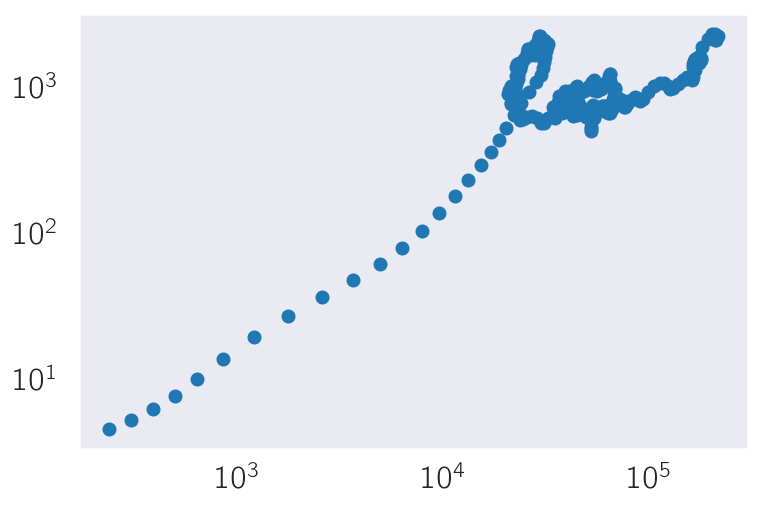

In [93]:
x = us.cases.diff().rolling(window=10, win_type='gaussian',
                           center=True).mean(std=2)
y = us.deaths.diff().rolling(window=10, win_type='gaussian',
                           center=True).mean(std=2)

plt.plot(x, y, 'o')
plt.xscale('log')
plt.yscale('log')

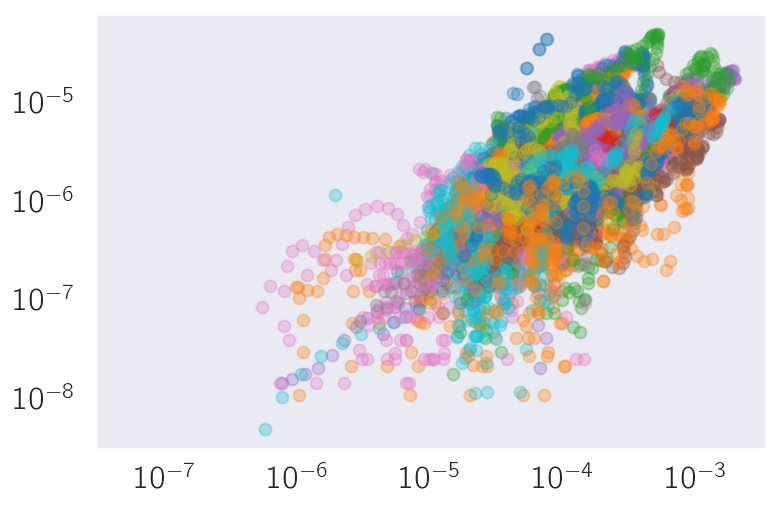

In [98]:
for n, g in df.groupby('state'):
    d = g[g.date >= g[g.deaths > 0].date.min()].copy()
    x = d.normedPopCases.diff().rolling(window=10, win_type='gaussian',
                               center=True).mean(std=2)
    y = d.normedPopDeaths.diff().rolling(window=10, win_type='gaussian',
                               center=True).mean(std=2)
    plt.plot(x, y, 'o', alpha=0.3)

plt.xscale('log')
plt.yscale('log')

Alabama 243 1
Alabama 243 0
Alaska 237 0.97
Alaska 1 2.5e-56
----------------------------------> 237 1
Arizona 241 1
Arizona 241 0
Arkansas 93 0.89
Arkansas 238 0
----------------------------------> 93 238
California 243 1
California 243 0
Colorado 205 0.71
Colorado 247 0
----------------------------------> 205 247
Connecticut 249 1
Connecticut 249 0
Delaware 225 0.99
Delaware 247 0
----------------------------------> 225 247
District of Columbia 234 0.93
District of Columbia 131 1.2e-49
----------------------------------> 234 131
Florida 232 0.96
Florida 119 2.5e-33
----------------------------------> 232 119
Georgia 249 1
Georgia 249 0
Hawaii 1 0.71
Hawaii 233 0
----------------------------------> 1 233
Idaho 243 1
Idaho 243 0
Illinois 190 0.86
Illinois 243 0
----------------------------------> 190 243
Indiana 239 0.97
Indiana 246 0
----------------------------------> 239 246
Iowa 180 0.91
Iowa 236 0
----------------------------------> 180 236
Kansas 218 0.81
Kansas 1 2.2e-45
-------

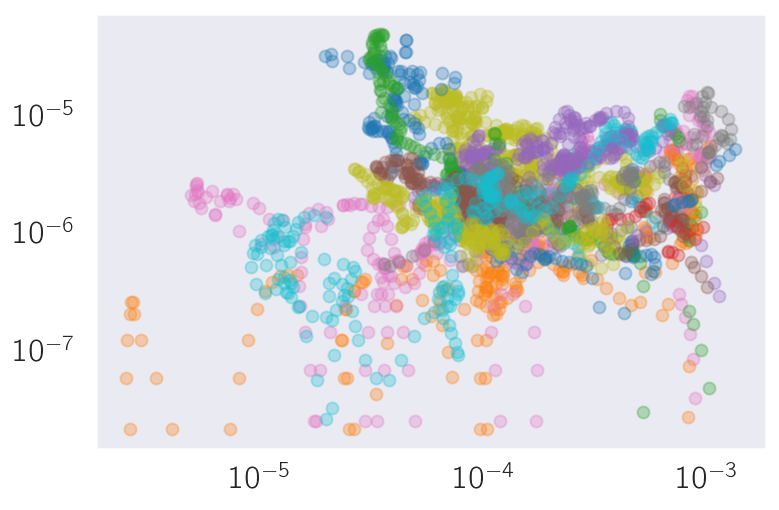

In [126]:
from scipy.stats import spearmanr as corr

l = []
for n, g in df.groupby('state'):
    d = g[g.date >= g[g.normedPopDeaths > 5 * 10 ** -6].date.min()].copy()
    if d .date.nunique() <= 7:
        continue
    x = d.normedPopCases.diff().rolling(window=10, win_type='gaussian',
                               center=True).mean(std=2)
    y = d.normedPopDeaths.diff().rolling(window=10, win_type='gaussian',
                                center=True).mean(std=2) 
    max_ct = 1
    max_pt = 1
    min_p = 1
    max_c = 0
    
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    for t in np.arange(1, np.min([250, x.size - 2])):
        if np.isnan(y).any():
            print(n, d.deaths.diff(), y)
        c, p = corr(x[t:], y[:-t])
        if c > max_c:
            max_ct = t
            max_c = c
        if p < min_p:
            max_pt = t
            min_p = p

    print(n, max_ct, '{0:.2g}'.format(max_c))
    print(n, max_pt, '{0:.2g}'.format(min_p))
    if max_ct != max_pt:
        print("---------------------------------->", max_ct, max_pt)
    plt.plot(x[max_pt:], y[:-max_pt], 'o', alpha=0.3)
    
    l += [[n, max_ct, max_pt, max_c, min_p]]
    
plt.xscale('log')
plt.yscale('log')

Text(0.5, 0, '')

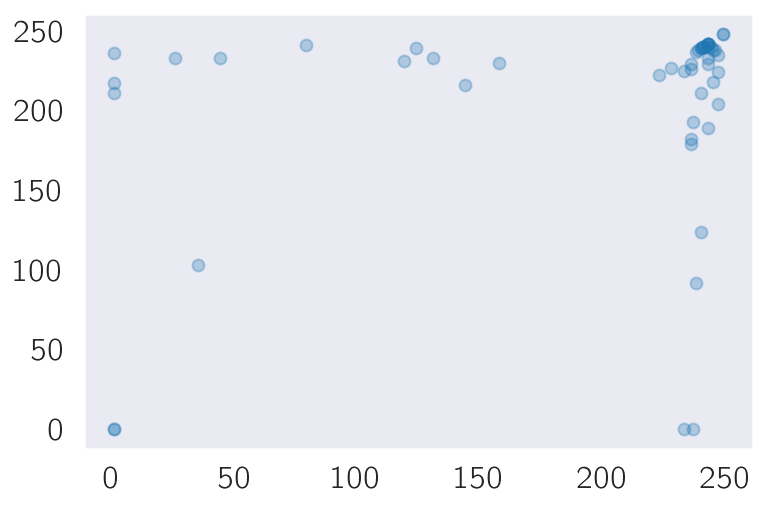

In [127]:
times = pd.DataFrame(l, columns=['State', 'MaxCT', 'MaxPT', 'MaxC', 'MinP'])
plt.plot(times.MaxPT, times.MaxCT, 'o', alpha=0.3)
plt.xlabel('')

In [128]:
from scipy import signal
x = us.cases.diff().rolling(window=10, win_type='gaussian',
                           center=True).mean(std=2)
y = us.deaths.diff().rolling(window=10, win_type='gaussian',
                           center=True).mean(std=2)

x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
corr = signal.correlate(x, y, mode='same')

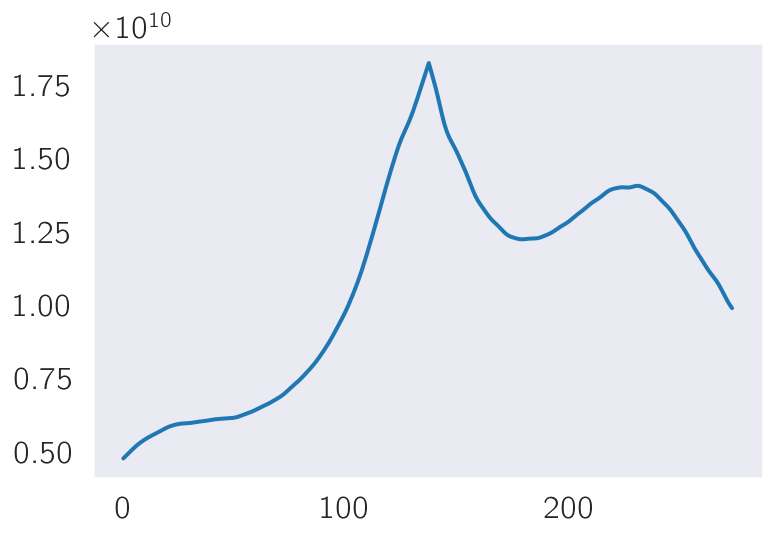

In [116]:
plt.plot(corr)

In [170]:
import numpy as np
from scipy.signal import argrelextrema
x = us.cases.diff().rolling(window=40, win_type='gaussian',
                           center=True).mean(std=10)
y = us.deaths.diff().rolling(window=40, win_type='gaussian',
                           center=True).mean(std=10)

# for local maxima
case_extrema = argrelextrema(x.values, np.greater)
death_extrema = argrelextrema(y.values, np.greater)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


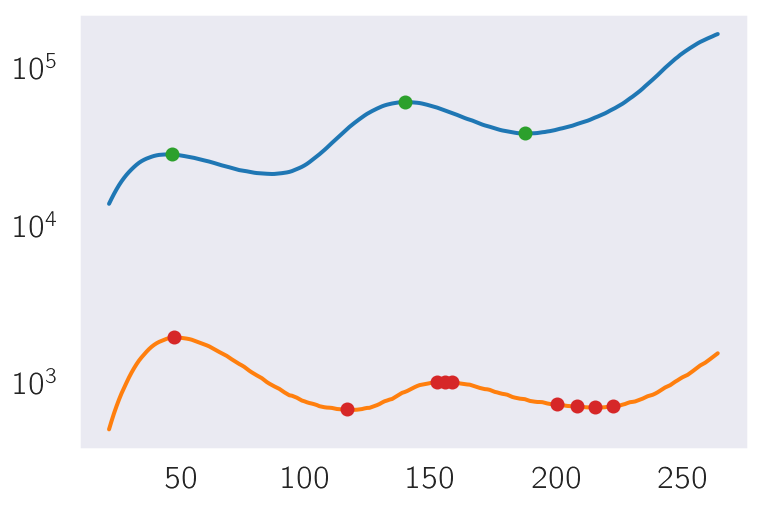

In [177]:
plt.plot(x.values)
plt.plot(y.values)
plt.plot(case_extrema[0], x.values[case_extrema[0]], 'o')
plt.plot(death_extrema[0], y.values[death_extrema[0]], 'o')
plt.yscale('log')

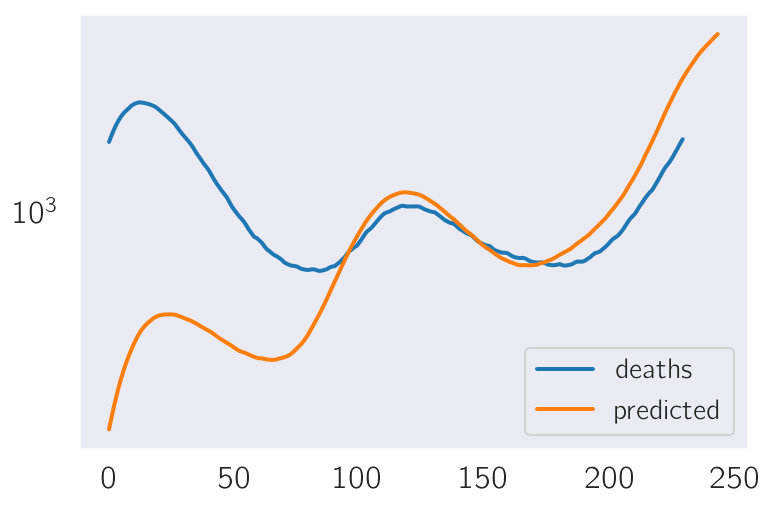

In [215]:
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
plt.plot(y[14:].values, label='deaths')
plt.plot(x.values / 55, label='predicted')
# plt.plot(y[~np.isnan(y)].values[:-16] * 55)
plt.legend()
plt.yscale('log')

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,  523.27436145,  590.51637851,  662.07604028,
        734.95826305,  810.48619075,  886.40155808,  961.1745775 ,
       1038.30301859, 1120.71751258, 1201.72394634, 1280.99908978,
       1358.75994916, 1433.47659487, 1501.0387575 , 1565.53183279,
       1631.45158899, 1694.29680168, 1751.32506039, 1801.13783282,
       1844.68586931, 1880.89009281, 1909.62399742, 1939.42456821,
       1967.16107091, 1986.20593442, 1999.52018814, 2006.6674197 ,
       2005.2184315 , 1999.62659996, 1993.47701537, 1984.640704  ,
       1972.82341804, 1959.50402951, 1941.40324047, 1915.55369088,
       1889.07918582, 1865.09202731, 1839.50129743, 1813.42026

In [187]:
y.values[:-16]

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,  523.27436145,  590.51637851,  662.07604028,
        734.95826305,  810.48619075,  886.40155808,  961.1745775 ,
       1038.30301859, 1120.71751258, 1201.72394634, 1280.99908978,
       1358.75994916, 1433.47659487, 1501.0387575 , 1565.53183279,
       1631.45158899, 1694.29680168, 1751.32506039, 1801.13783282,
       1844.68586931, 1880.89009281, 1909.62399742, 1939.42456821,
       1967.16107091, 1986.20593442, 1999.52018814, 2006.6674197 ,
       2005.2184315 , 1999.62659996, 1993.47701537, 1984.640704  ,
       1972.82341804, 1959.50402951, 1941.40324047, 1915.55369088,
       1889.07918582, 1865.09202731, 1839.50129743, 1813.42026